# Laser noise

## Introduction
Laser noises were introduced in the introductory tutorial [Simulating sequences with errors and noises](noisy_sim.nblink). They will be further detailed in this notebook. We recommend you to check the introductory tutorial before going through this one.

The laser noises model errors coming from the laser-atom interaction itself, encapsulating effects like:

- **Doppler damping**: the atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe doppler-shifted due to thermal motion. This can be seen as a shift in the detuning frequency of the laser.
- **Waist of the laser**: for global pulses, the laser amplitude has a Gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.
- **Amplitude fluctuations**: the `amp_sigma` parameter dictates fluctuations in the laser amplitude from pulse to pulse. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, QutipEmulator
from pulser.devices import AnalogDevice
from pulser.waveforms import RampWaveform

## Single atom noisy simulations

### Sequence preparation

We start with a single atom away from the center of the register.

In [2]:
reg = Register.from_coordinates([(0, 30)], prefix="q")

Then we act on this atom with a Constant Pulse, such that it oscillates between the ground state and excited Rydberg state (Rabi oscillations):

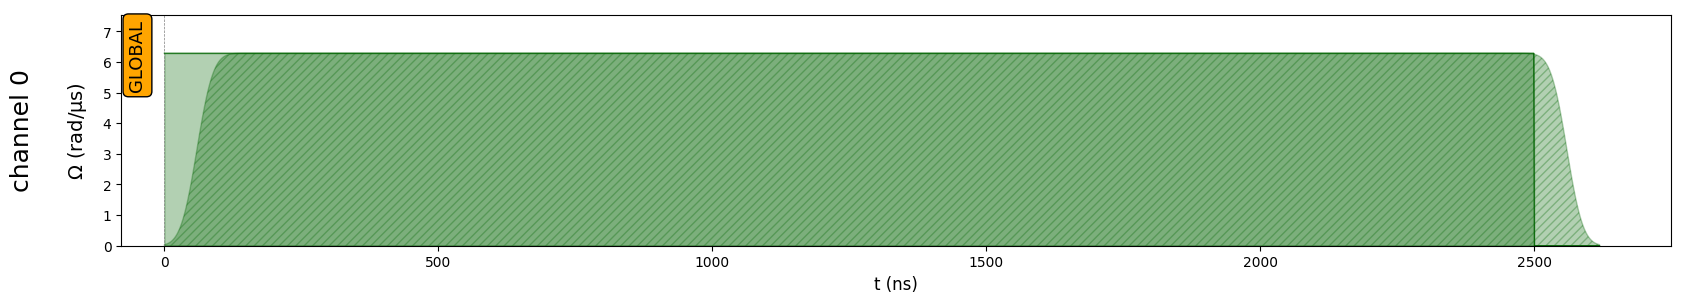

In [3]:
seq = Sequence(reg, AnalogDevice)
seq.declare_channel("channel 0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

Then we create the simulation object with which we will add noises.

In [4]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.05)
sim.set_evaluation_times(0.4)
res_clean = sim.run()
obs = qutip.basis(2, 0).proj()
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)

### Doppler shift

As for any noise, the doppler noise is set via a `SimConfig` object. Note that you can change the standard deviation of the doppler noise, which is $k \times \sqrt{k_B T / m}$ where $k$ is the norm of the effective wavevector of the lasers, by changing the temperature field setting it in $\mu K$.

We'll exaggerate the temperature to emphasize the effects of the Doppler shift (the default temperature being $50 \mu K$).

In [5]:
config_doppler = SimConfig(
    noise="doppler", runs=100, temperature=5000, samples_per_run=10
)
sim.set_config(config_doppler)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       10
Noise types:           doppler
Temperature:           5000.0µK


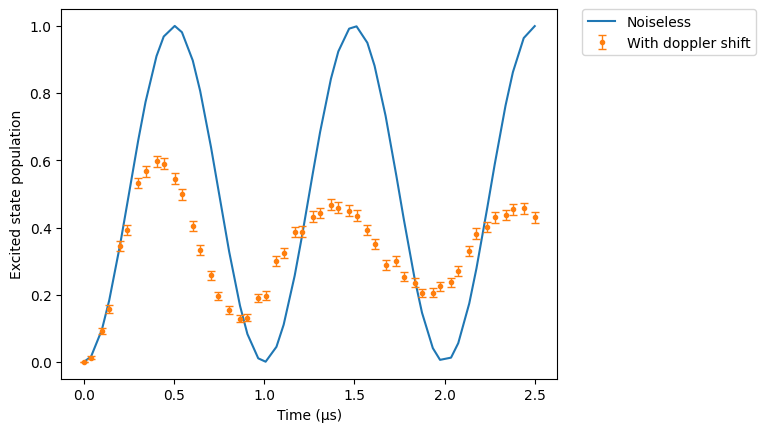

In [6]:
res_clean.plot(obs, label="Noiseless")
res_doppler = sim.run()
res_doppler.plot(obs, label="With doppler shift")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

### Amplitude noise

When activated, we switch to a description of the laser amplitude as a gaussian profile whose standard deviation is the `laser_waist`. 
Furthermore, the amplitude of the laster fluctuates according to a gaussian profile with standard deviation `amp_sigma`.

In [7]:
sim.reset_config()
config_amp_noise = SimConfig(
    noise="amplitude",
    runs=100,
)
sim.set_config(config_amp_noise)
sim.show_config()

Options:
----------
Number of runs:        100
Samples per run:       5
Noise types:           amplitude
Laser waist:           175.0μm
Amplitude standard dev.:  0.05


Notice we are now using 100 runs in order to see the effects of the modulations clearly.

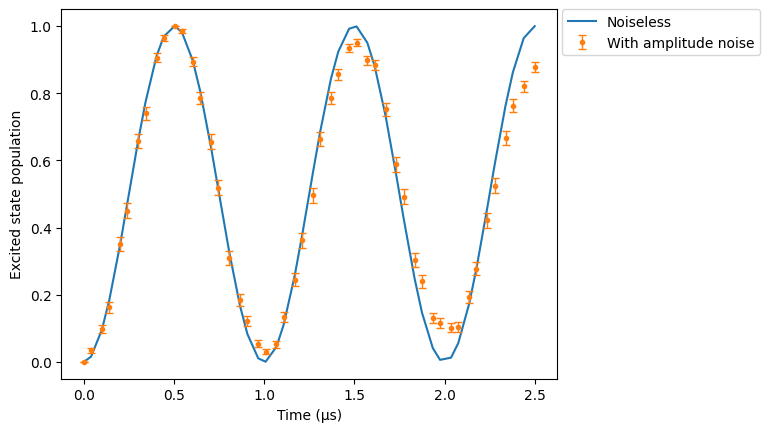

In [8]:
res_clean.plot(obs, label="Noiseless")
res_doppler = sim.run()
res_doppler.plot(obs, label="With amplitude noise")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

Even with the default parameters, we still observe a small damping of the Rabi oscillations.

## Multiple Atoms

We will now run the AFM state preparation sequence from the Pulser tutorial with our noise models and compare the results to the noiseless case.

At this stage, you know how to manipulate the different laser noises. In this multi-qubit case, we will combine all these effects.

In [9]:
# Parameters in rad/µs and ns
omega_max = 2.0 * 2 * np.pi
delta_0 = -6 * 2 * np.pi
delta_f = 2 * 2 * np.pi

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

U = 2 * np.pi
R_interatomic = AnalogDevice.rydberg_blockade_radius(U)

n_side = 3
reg = Register.rectangle(n_side, n_side, R_interatomic * 0.9, prefix="q")

rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, AnalogDevice)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

In [10]:
config_all_noise = SimConfig(
    noise=("doppler", "amplitude"),
    runs=100,
    samples_per_run=10,
    amp_sigma=0.1,
    laser_waist=100,
    temperature=100,
)
simul = QutipEmulator.from_sequence(
    seq,
    sampling_rate=0.05,
    evaluation_times=0.1,
    config=config_all_noise,  # Take 10% of the time steps as evaluation times (7 time steps)
)
noisy_results = simul.run()

simul.reset_config()
clean_results = simul.run()

We will plot the simulation results by sampling the final states. Rather than using the `sample_final_state()` method on the noisy results object (which just samples from the last realization of the noisy simulation), we need to extract the `Counter` object from the `NoisyResults.results` object, which has accumulated the samples of all the simulated runs.

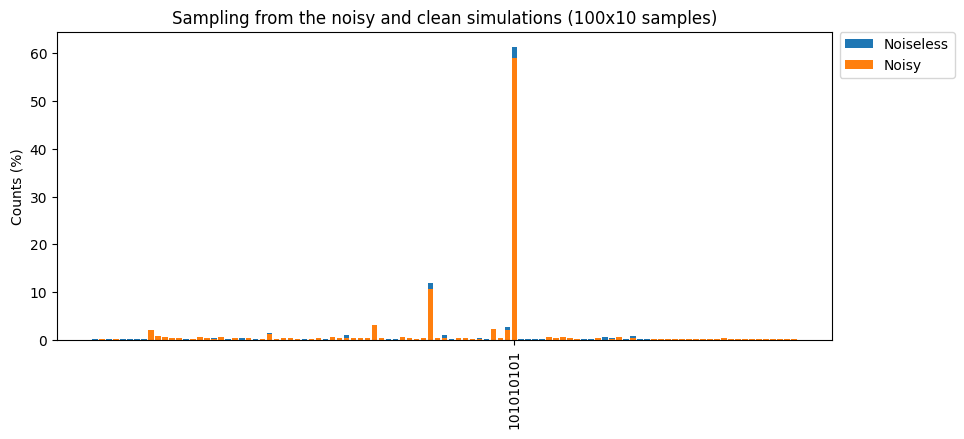

In [11]:
plt.figure(figsize=(10, 4))
noisy_count = noisy_results.results[
    -1
]  # Extract the Counter object from the last evaluated time step.
clean_count = clean_results.sample_final_state(
    N_samples=100 * 10
)  # Compare with 100 runs of 10 samples each

clean_most_freq = {k: 100 * v / 1000 for k, v in clean_count.items()}
noisy_most_freq = {k: 100 * v for k, v in noisy_count.items()}

plt.bar(
    clean_most_freq.keys(), list(clean_most_freq.values()), label="Noiseless"
)
plt.bar(noisy_most_freq.keys(), list(noisy_most_freq.values()), label="Noisy")

# Only show the xticks to the most frequent states:
most_freq = sorted(noisy_count, key=noisy_count.get, reverse=True)[:1]

plt.ylabel("Counts (%)")
plt.xticks(most_freq, rotation=90)
plt.title("Sampling from the noisy and clean simulations (100x10 samples)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.show()

The bars represent the simulation results as populations of bitstrings. They're colored blue for the noiseless simulation, and orange for the noisy one. We clearly identify the antiferromagnetic state as the most populated one in both cases, but it is slightly less populated in the noisy case, while some other bitstrings, not present in the noiseless case, appear.